<a href="https://colab.research.google.com/github/AnshulH/NLP-DL-Group2/blob/lstm/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -r /content/NLP-DL-Group2/
!cd /content && git clone https://github.com/AnshulH/NLP-DL-Group2

Cloning into 'NLP-DL-Group2'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 120 (delta 35), reused 18 (delta 5), pack-reused 46
Receiving objects: 100% (120/120), 30.93 MiB | 18.04 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words # added for detecting English words
import string
import nltk
import calendar
import re
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import sys
import argparse
import os

nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)
device

device(type='cpu')

In [ ]:
def decode(vocab,corpus):
    
    text = ''
    for i in range(len(corpus)):
        wID = corpus[i]
        text = text + vocab[wID] + ' '
    return(text)

def encode(words,text):
    corpus = []
    tokens = text.split(' ')
    for t in tokens:
        try:
            wID = words[t][0]
        except:
            wID = words['<unk>'][0]
        corpus.append(wID)
    return(corpus)

def read_encode(file_name,vocab,words,corpus,threshold):
    
    wID = len(vocab)
    if threshold > -1:
        with open(file_name,'rt') as f:
            for line in f:
                line = line.replace('\n','')
                tokens = line.split(' ')
                for t in tokens:
                    try:
                        elem = words[t]
                    except:
                        elem = [wID,0]
                        vocab.append(t)
                        wID = wID + 1
                    elem[1] = elem[1] + 1
                    words[t] = elem

        temp = words
        words = {}
        vocab = []
        wID = 0
        words['<unk>'] = [wID,100]
        wID = 1
        words['< start_bio >'] = [wID,100]
        wID = 2
        words['< end_bio >'] = [wID,100]
        vocab.append('<unk>')
        vocab.append('< start_bio >')
        vocab.append('< end_bio >')
        for t in temp:
            if temp[t][1] >= threshold:
                vocab.append(t)
                wID = wID + 1
                words[t] = [wID,temp[t][1]]
            
                    
    with open(file_name,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(' ')
            for t in tokens:
                try:
                    wID = words[t][0]
                except:
                    wID = words['<unk>'][0]
                corpus.append(wID)
                
    return [vocab,words,corpus]

In [ ]:
def read_alltext(file_name,batch_size,vocab,words):
  '''
  tokenizes data, removes digits, converts to wIDs, and provides a tensor of batched inputs
  inputs: 
    file_name = a complete file path to a mixed dataset containing text and labels
    sequence_length = the length of the desired input array
  outputs:
    x = a tensor containing wIDs of the input
  '''
  word_dict = words
  wid = []
  real_wid = word_dict.get('[REAL]')[0]
  fake_wid = word_dict.get('[FAKE]')[0]

  with open(file_name) as input:
    all_text = input.readlines()

  for line in all_text:
    line = line.strip()
    line = re.sub("[\d-]", "",line)
    if "< start_bio >" in line:
      try:
        wid.append(1)
      except:
        continue
    elif "< end_bio >" in line:
        wid.append(2)
    elif "[REAL]" in line:
        wid.append(real_wid)
    elif "[FAKE]" in line:
        wid.append(fake_wid)
    else:
      line = [token for token in word_tokenize(line.lower())]
      for token in line:
        word_info = word_dict.get(token)
        if word_info is None:
          wid.append(0) 
        else:
          wid.append(word_info[0])

  x = torch.tensor(np.asarray(wid)) 
  num_batches = x.shape[0] // batch_size 
  x = x[:num_batches * batch_size] 
  x = x.view(batch_size, num_batches)   

  return x,vocab,words

In [ ]:
def get_batch(data, seq_len, num_batches, idx):
    src = data[:, idx:idx+seq_len]                   
    target = data[:, idx+1:idx+seq_len+1]             
    return src, target

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import sys
import argparse
import os

class FFNN(nn.Module):
    def __init__(self, vocab, words,d_model, d_hidden, dropout):
        super().__init__() 
    
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.d_model = d_model
        self.d_hidden = d_hidden
        self.dropout = dropout
        self.embeds = nn.Embedding(self.vocab_size,d_model)
#          {perform other initializations needed for the FFNN}

    def forward(self, src):
        embeds = self.dropout(self.embeds(src))
#          {add code to implement the FFNN}
        pass
        # return x
                
    def init_weights(self):
        pass
#          {perform initializations}
             
class LSTM(nn.Module):
    def __init__(self,vocab,words,d_model,d_hidden,n_layers,dropout_rate, tie_weights):
        super().__init__()
        
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.n_layers = n_layers
        self.d_hidden = d_hidden
        self.d_model = d_model
        self.embeds = nn.Embedding(self.vocab_size,d_model)
#          {perform other initializations needed for the LSTM}
        self.lstm = nn.LSTM(d_model, d_hidden, n_layers, dropout=dropout_rate, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(d_hidden, self.vocab_size)

        if tie_weights:
          assert d_model == d_hidden, 'cannot tie, check dims'
          self.embeds.weight = self.fc.weight
        self.init_weights()
        
    def forward(self,src,h):
        embeds = self.dropout(self.embeds(src))  
        out, h = self.lstm(embeds, h) 
        out = self.dropout(out)
        predict = self.fc(out) 
        return predict, h
    
    def init_weights(self):
        emb_range = 0.1
        init_range = 1/math.sqrt(self.d_hidden)
        self.embeds.weight.data.uniform_(-emb_range, emb_range)
        self.fc.weight.data.uniform_(-init_range, init_range)
        self.fc.bias.data.zero_()
        for i in range(self.n_layers):
            self.lstm.all_weights[i][0] = torch.FloatTensor(self.d_model,
                    self.d_hidden).uniform_(-init_range, init_range) 
            self.lstm.all_weights[i][1] = torch.FloatTensor(self.d_hidden, 
                    self.d_hidden).uniform_(-init_range, init_range) 
        
    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.n_layers, batch_size, self.d_hidden).to(device)
        cell = torch.zeros(self.n_layers, batch_size, self.d_hidden).to(device)
        return hidden, cell

    def detach_hidden(self, hidden):
      hidden, cell = hidden
      hidden = hidden.detach()
      cell = cell.detach()
      return hidden,cell
 
def main():
    
    parser = argparse.ArgumentParser()
    parser.add_argument('-d_model', type=int, default=100)
    parser.add_argument('-d_hidden', type=int, default=100)
    parser.add_argument('-n_layers', type=int, default=2)
    parser.add_argument('-batch_size', type=int, default=20)
    parser.add_argument('-seq_len', type=int, default=30)
    parser.add_argument('-printevery', type=int, default=5000)
    parser.add_argument('-window', type=int, default=3)
    parser.add_argument('-epochs', type=int, default=20)
    parser.add_argument('-lr', type=float, default=0.0001)
    parser.add_argument('-dropout', type=int, default=0.35)
    parser.add_argument('-clip', type=int, default=2.0)
    parser.add_argument('-model', type=str,default='LSTM')
    parser.add_argument('-savename', type=str,default='lstm')
    parser.add_argument('-loadname', type=str)
    parser.add_argument('-trainname', type=str,default='wiki.train.txt')
    parser.add_argument('-validname', type=str,default='wiki.valid.txt')
    parser.add_argument('-testname', type=str,default='wiki.test.txt')

    params = {
        'd_model': 512,
        'd_hidden': 512,
        'n_layers': 2,
        'batch_size': 20,
        'seq_len': 30,
        'printevery': 500,
        'window': 3,
        'epochs': 20,
        'lr': 0.0001,
        'dropout': 0.35,
        'clip': 2.0,
        'model': 'LSTM',
        'savename': 'lstm',
        'loadname': None,
        'trainname': '/content/NLP-DL-Group2/hw#1/mix.train.tok',
        'validname': '/content/NLP-DL-Group2/hw#1/mix.valid.tok',
        'testname': '/content/NLP-DL-Group2/hw#1/mix.test.tok'
    }
    parser.add_argument("-f", required=False)
    
    # params = parser.parse_args()    
    # torch.manual_seed(0)
    
    [vocab,words,train] = read_encode(params['trainname'],[],{},[],3)
    print('vocab: %d train: %d' % (len(vocab),len(train)))
    [vocab,words,test] = read_encode(params['testname'],vocab,words,[],-1)
    print('vocab: %d test: %d' % (len(vocab),len(test)))
    params['vocab_size'] = len(vocab)

    train_loader = read_encode(params['trainname'],[],{},[],3)
    
    if params['model'] == 'FFNN':
      pass
#          {add code to instantiate the model, train for K epochs and save model to disk}
        
    if params['model'] == 'LSTM':
      pass

    if params['model'] == 'FFNN_CLASSIFY':
      pass
#          {add code to instantiate the model, recall model parameters and perform/learn classification}

    if params['model'] == 'LSTM_CLASSIFY':
      pass
#          {add code to instantiate the model, recall model parameters and perform/learn classification}
        
    print(params)
    
if __name__ == "__main__":
    main()

vocab: 35152 train: 3012820
vocab: 35152 test: 395279
{'d_model': 512, 'd_hidden': 512, 'n_layers': 2, 'batch_size': 20, 'seq_len': 30, 'printevery': 500, 'window': 3, 'epochs': 20, 'lr': 0.0001, 'dropout': 0.35, 'clip': 2.0, 'model': 'LSTM', 'savename': 'lstm', 'loadname': None, 'trainname': '/content/NLP-DL-Group2/hw#1/mix.train.tok', 'validname': '/content/NLP-DL-Group2/hw#1/mix.valid.tok', 'testname': '/content/NLP-DL-Group2/hw#1/mix.test.tok', 'vocab_size': 35152}


In [ ]:
def LSTM_train(model, data, optimizer, criterion, batch_size, seq_len, clip, device):

  epoch_loss = 0
  model.train()

  num_batches = data.shape[-1]
  data = data[:, :num_batches - (num_batches -1) % seq_len]
  num_batches = data.shape[-1]

  hidden = model.init_hidden(batch_size, device)
    
  for idx in range(0, num_batches - 1, seq_len):  # The last batch can't be a src
      optimizer.zero_grad()
      hidden = model.detach_hidden(hidden)

      src, target = get_batch(data, seq_len, num_batches, idx)
      src, target = src.to(device), target.to(device)
      batch_size = src.shape[0]
      prediction, hidden = model(src, hidden)               

      prediction = prediction.reshape(batch_size * seq_len, -1)   
      target = target.reshape(-1)
      loss = criterion(prediction, target)
      
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()
      epoch_loss += loss.item() * seq_len
    
  return math.exp(epoch_loss / num_batches)
  
# [vocab,words,train] = read_encode('/content/NLP-DL-Group2/hw#1/mix.train.tok',[],{},[],3)

# criterion = nn.CrossEntropyLoss()
# data = all_text
# batch_size = 20
# seq_len = 30
# clip = 2.0

# model = LSTM(vocab,words,512,512,2,.35,True) 
# optimizer = optim.Adam(model.parameters(), lr=.0008)
# print(LSTM_train(model,data,optimizer,criterion,batch_size,seq_len,clip,device))

In [ ]:
def evaluate(model, data, criterion, batch_size, seq_len, device):

    epoch_loss = 0
    model.eval()
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for idx in range(0, num_batches - 1, seq_len):
            hidden = model.detach_hidden(hidden)
            src, target = get_batch(data, seq_len, num_batches, idx)
            src, target = src.to(device), target.to(device)
            batch_size= src.shape[0]

            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            target = target.reshape(-1)

            loss = criterion(prediction, target)
            epoch_loss += loss.item() * seq_len
    return math.exp(epoch_loss / num_batches)

In [ ]:
encodings = read_encode('/content/NLP-DL-Group2/hw#1/mix.train.tok',[],{},[],3) 
train_data,vocab,words = read_alltext('/content/NLP-DL-Group2/hw#1/mix.train.tok',20,encodings[0],encodings[1])
valid_data,vocab,words = read_alltext('/content/NLP-DL-Group2/hw#1/mix.valid.tok',20,vocab,words)
test_data,vocab,words = read_alltext('/content/NLP-DL-Group2/hw#1/mix.test.tok',20,vocab,words)

In [ ]:
criterion = nn.CrossEntropyLoss() 
batch_size = 20
seq_len = 30
clip = 2.0
n_epochs = 25
saved = True

model = LSTM(vocab,words,512,512,2,.35,True).to(device)
optimizer = optim.Adam(model.parameters(), lr=.0008)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=.0008)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)


In [ ]:
train = []
valid = []
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    train_loss = LSTM_train(model, train_data, optimizer, criterion, 
                20, seq_len, clip, device)
    valid_loss = evaluate(model, valid_data, criterion, 20, 
                seq_len, device)
    
    lr_scheduler.step(valid_loss)

    print(f'\tTrain Perplexity: {train_loss:.3f}')
    print(f'\tValid Perplexity: {valid_loss:.3f}')

    train.append(train_loss)
    valid.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-lstm_lm.pt')

	Train Perplexity: 179.475
	Valid Perplexity: 66.991
	Train Perplexity: 73.545
	Valid Perplexity: 49.944
	Train Perplexity: 56.900
	Valid Perplexity: 43.796
	Train Perplexity: 48.883
	Valid Perplexity: 40.910
	Train Perplexity: 43.876
	Valid Perplexity: 39.106
	Train Perplexity: 40.472
	Valid Perplexity: 37.886
	Train Perplexity: 38.008
	Valid Perplexity: 37.348
	Train Perplexity: 36.095
	Valid Perplexity: 36.881
	Train Perplexity: 34.562
	Valid Perplexity: 36.562
	Train Perplexity: 33.369
	Valid Perplexity: 36.475
	Train Perplexity: 32.383
	Valid Perplexity: 36.277
	Train Perplexity: 31.519
	Valid Perplexity: 36.230
	Train Perplexity: 30.808
	Valid Perplexity: 36.198
	Train Perplexity: 30.158
	Valid Perplexity: 36.093
	Train Perplexity: 29.618
	Valid Perplexity: 36.174
	Train Perplexity: 27.475
	Valid Perplexity: 35.457
	Train Perplexity: 26.755
	Valid Perplexity: 35.341
	Train Perplexity: 26.308
	Valid Perplexity: 35.298
	Train Perplexity: 25.941
	Valid Perplexity: 35.282
	Train Perp

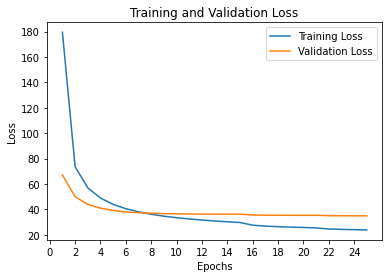

In [ ]:
from matplotlib.pylab import plt
from numpy import arange

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 26)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train , label='Training Loss')
plt.plot(epochs, valid, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 26, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
# save code
torch.save({
            'epoch': 10,
            'batch': 20,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(), 
            }, "/content/drive/My Drive/lstm_mixed.pt")

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/lstm_mixed.pt',  map_location=device)['model_state_dict'])
test_loss = evaluate(model, test_data, criterion, batch_size, seq_len, device)
print(f'Test Perplexity: {test_loss:.3f}')

Test Perplexity: 35.324


In [ ]:
def make_tensors(file_name,vocab,words):
  '''
  creates a list of tuples containing a list with the tokenized bio and a fake/real label

  inputs: 
    file_name = a complete file path to a mixed dataset containing text and labels 
  outputs:
    x = a tensor containing wIDs for each bio
    y = a tensor containing the corresponding label for each input
  '''
  
  # stop = set(stopwords.words('english') + list(string.punctuation))
  with open(file_name) as input:
    all_text = input.readlines()

# if anybody wants to do some work on the tokenization section, 
# you should work with the split_bios array, since it contains actual words

# split_bios = [([bio1, tokens1],[REAL]),([bio2, tokens2],[FAKE])]
  split_bios = []
  line_text = []
  seq_status = 0

  # seq_status = 0 marks the start of the bio
  # seq_status = 1 is the main text of the bio
  # seq_status = 2 is the end of the bio
  for line in all_text:
    line = line.strip()
    if "< start_bio >" in line:
      seq_status = 0
      continue
    if "< end_bio >" in line:
      seq_status = 2
      line_text.append(line)
      continue
    if seq_status == 0:
      # bio_person = line.strip(" = ").lower().split()
      # stop.update(bio_person) # could remove important words if name is meaningful
      seq_status = 1
    if seq_status == 1:
      line = re.sub("[\d-]", "",line)
      line = [token for token in word_tokenize(line.lower())]
      # line = [token for token in word_tokenize(line.lower()) if token not in stop]
      if len(line) > 0:
        line_text.extend(line)
    if seq_status == 2 and line !="":
      # stop -= set(bio_person)
      # if line == '[FAKE]': #updated code so now fake / real is binary
      #   line = 0
      # elif line == '[REAL]':
      #   line = 1
      # else:
      #   continue  
      split_bios.append((line_text,line))
      line_text = []
 
  word_dict = words  
  bio_array = [] 
  y = []

  for bio in split_bios:
    wid = []
    wid.append(1)
    for token in bio[0]:
      word_info = word_dict.get(token)
      if word_info is None:
        wid.append(0)
      else:
        wid.append(word_info[0])
    # if len(wid) > seq_len:
    #   wid = wid[:seq_len-2]
    #   wid.append(word_dict.get('< end_bio >')[0]) #makes last token "end bio" no matter what
    #   wid.append(word_dict.get(bio[1])[0])
    # elif len(wid) < seq_len:
    #   wid.append(word_dict.get(bio[1])[0])
    #   pad_size = seq_len - len(wid)
    #   wid.extend(np.ones(pad_size,dtype=int))
    bio_array.append(np.asarray(wid)) 
    real_wid = word_dict.get('[REAL]')[0]
    fake_wid = word_dict.get('[FAKE]')[0] 
    if real_wid == word_dict.get(bio[1])[0]: 
        y.append(real_wid)
    elif fake_wid == word_dict.get(bio[1])[0]:
        y.append(fake_wid) 
    else:
        print('error')
       
  x = bio_array
  y = y  
  return x,y

In [ ]:
word_tensors = make_tensors('/content/NLP-DL-Group2/hw#1/mix.train.tok',vocab,words)

In [ ]:
def get_input_batch(data, seq_len, idx):
    src = data[:, idx:idx+seq_len]                     
    return src 

In [ ]:
input = torch.tensor(word_tensors[0][100],device = device).reshape(-1,1)
def LSTM_Classify(input, model, vocab, word_dict, device, seed=None):
  real_wid = word_dict.get('[REAL]')[0]
  fake_wid = word_dict.get('[FAKE]')[0]
  if seed is not None:
      torch.manual_seed(seed)
  model.eval() 
  input = torch.transpose(input, 0, 1) 
  num_batches = input.shape[-1]  
  input = input[:,(num_batches -1) % seq_len :]
  num_batches = input.shape[-1]  
  batch_size = 1  
  hidden = model.init_hidden(batch_size, device)
  prediction = None
  for idx in range(0, num_batches - 1, seq_len): 
            hidden = model.detach_hidden(hidden)
            src  = get_input_batch(input, seq_len, idx)
            src  = src.to(device)  
            prediction, hidden = model(src, hidden)

  with torch.no_grad():
      if(prediction == None): 
        print(input.size())
        return 124
      prediction = prediction.reshape(batch_size * seq_len, -1)  
      probs = torch.softmax(prediction[-1, :] , dim=-1)   
      real_prediction = probs[real_wid]
      fake_prediction = probs[fake_wid] 
      if real_prediction > fake_prediction:
        prediction = real_wid
      else:
        prediction = fake_wid
   
  return prediction 
LSTM_Classify(input,model,vocab,words,device)

124

In [ ]:
# print(len(word_tensors[1]))
y_true=[] 
y_pred=[]
correct = 0
# for index in range(500):
for index in range(len(word_tensors[1])):
  item = torch.tensor(word_tensors[0][index],device = device).reshape(-1,1)
  prediction = LSTM_Classify(item,model,vocab,words,device)
  actual = word_tensors[1][index] 
  if(prediction == 637):
    y_pred.append(1)
  else:
    y_pred.append(0)
  if(actual == 637):
    y_true.append(1)
  else:
    y_true.append(0)
  if prediction == actual:
    correct += 1
  
# print(correct/500)
print(correct)
print(correct/len(word_tensors[1]))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[2971,  942],
       [2252, 1797]])